# 03. VAR Model

**Mô hình:** Vector Autoregression (VAR)

**Thư viện:** statsmodels.tsa.api.VAR

**Metrics:** RMSFE, MAPE

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os

# Cấu hình hiển thị
plt.style.use('ggplot')

# Hàm tính MAPE
def calculate_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true[y_true == 0] = 1e-10 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("Đã import thư viện.")

Đã import thư viện.


In [17]:
# Load Data
df_train = pd.read_csv('../data/processed/train_clean.csv')
df_test = pd.read_csv('../data/processed/test_clean.csv')

# Fix Encoding
df_train.columns = [c.replace('垄', '¢') for c in df_train.columns]
df_test.columns = [c.replace('垄', '¢') for c in df_test.columns]

# Set Index
df_train['Fecha'] = pd.to_datetime(df_train['Fecha'])
df_test['Fecha'] = pd.to_datetime(df_test['Fecha'])
df_train = df_train.set_index('Fecha')
df_test = df_test.set_index('Fecha')

# --- CRITICAL STEP: Select Variables for VAR ---
target_col = 'Core CPI'

# 1. Identify "Base" Variables (use lag_1 as proxy since raw data is missing)
base_cols = [c for c in df_train.columns if "_lag_1" in c]
if target_col not in base_cols:
    base_cols.append(target_col)

# 2. Feature Selection (Top 4 correlated variables)
# This reduces 190+ columns down to 4, preventing overfitting
correlations = df_train[base_cols].corrwith(df_train[target_col]).abs().sort_values(ascending=False)
top_k = 4
selected_vars = correlations.index[:top_k].tolist()

# Ensure target is included
if target_col not in selected_vars:
    selected_vars = [target_col] + selected_vars[:top_k-1]

print(f"Selected Variables for VAR: {selected_vars}")

# 3. Create VAR Datasets
train_data = df_train[selected_vars].dropna()
test_data = df_test[selected_vars].dropna()

Selected Variables for VAR: ['Core CPI', 'Macroeconomic Expectations - Inflation (12 months)_lag_1', 'Private Credit - MN - Mortgage (mill S/)_lag_1', 'Headline CPI_lag_1']


In [18]:
# Initialize VAR
model = VAR(train_data)

# Select Optimal Lag (AIC)
# We allow the model to find the best lag structure (1, 2, or 3)
lag_order_results = model.select_order(maxlags=3)
optimal_lag = lag_order_results.aic
print(f"Optimal Lag Order (AIC): {optimal_lag}")

# Train Model
var_model = model.fit(optimal_lag)
print(var_model.summary())

Optimal Lag Order (AIC): 3
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 04, Dec, 2025
Time:                     14:52:57
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -25.5029
Nobs:                     109.000    HQIC:                  -26.2662
Log likelihood:           893.228    FPE:                2.33659e-12
AIC:                     -26.7869    Det(Omega_mle):     1.48884e-12
--------------------------------------------------------------------
Results for equation Core CPI
                                                                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------------------------------------------
const                                                               0.000819         0.000548       

d:\IS403.Q11\inflation-forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [19]:
# Forecast
lag_order = var_model.k_ar
input_data = train_data.values[-lag_order:]
n_obs = len(test_data)
pred = var_model.forecast(y=input_data, steps=n_obs)

# Create Forecast DataFrame
df_forecast = pd.DataFrame(pred, index=test_data.index, columns=selected_vars)

# Extract Target
y_true = test_data[target_col]
y_pred = df_forecast[target_col]

# Calculate Metrics
r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = calculate_mape(y_true, y_pred)

# Display Results
df_results = pd.DataFrame({
    'Metric': ['R2 Score', 'RMSE', 'MAE', 'MAPE (%)', 'Optimal Lag'],
    'Value': [r2, rmse, mae, mape, optimal_lag]
})

print(f"\nVAR Model Results for '{target_col}':")
display(df_results)


VAR Model Results for 'Core CPI':


,Metric,Value
0,R2 Score,0.192413
1,RMSE,0.105552
2,MAE,0.071260
3,MAPE (%),14.066903
4,Optimal Lag,3.000000


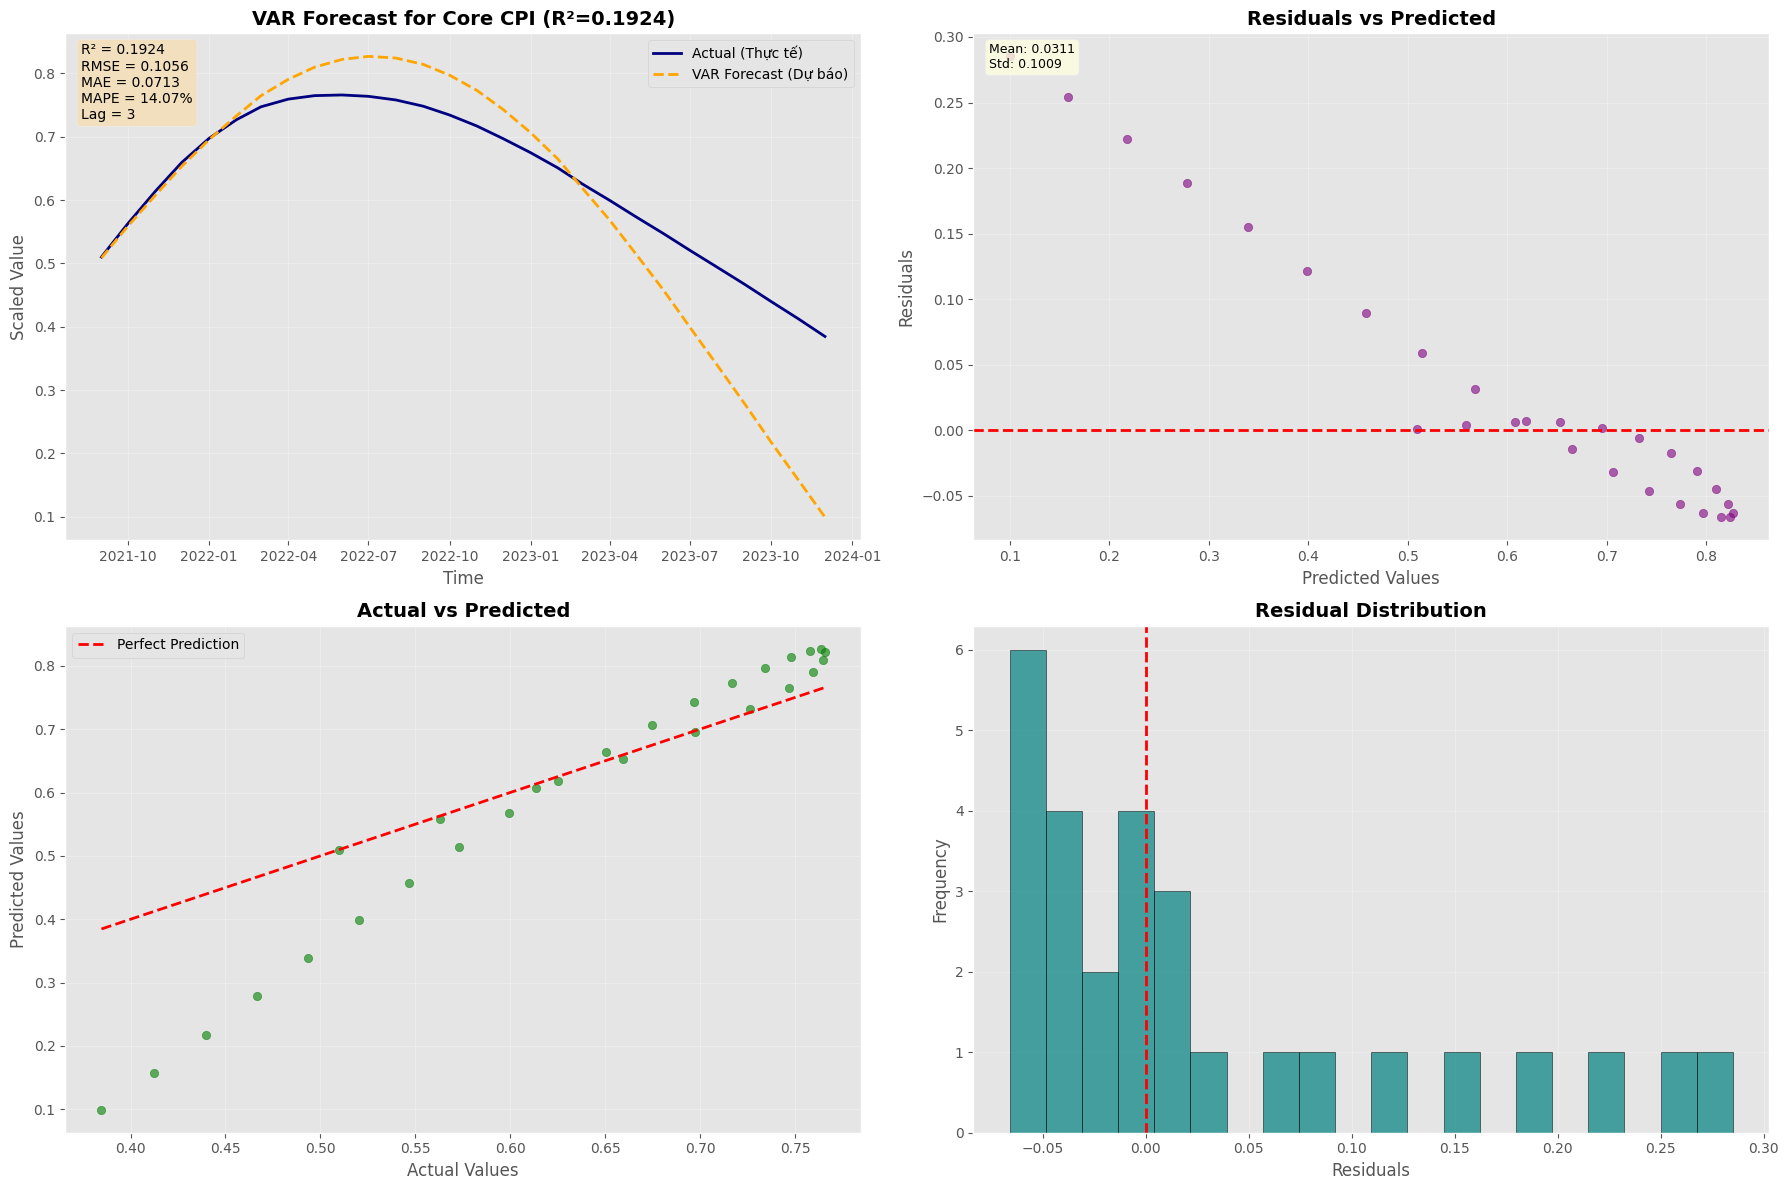

Đã lưu metrics vào: ../results/tables\var_metrics.csv
Đã lưu predictions vào: ../results/tables\var_predictions.csv
Đã lưu diagnostics plot vào: ../results/figures\var_diagnostics_plot.png


In [20]:
# Save Directories
OUTPUT_DIR_FIGURE = '../results/figures'
OUTPUT_DIR_TABLE = '../results/tables'
os.makedirs(OUTPUT_DIR_FIGURE, exist_ok=True)
os.makedirs(OUTPUT_DIR_TABLE, exist_ok=True)

# Save Metrics
metrics_filename = os.path.join(OUTPUT_DIR_TABLE, 'var_metrics.csv')
df_results.to_csv(metrics_filename, index=False)

# Save Predictions
predictions_df = pd.DataFrame({
    'Fecha': y_true.index,
    'Actual': y_true.values,
    'Predicted': y_pred.values
})
predictions_filename = os.path.join(OUTPUT_DIR_TABLE, 'var_predictions.csv')
predictions_df.to_csv(predictions_filename, index=False)

# === VISUALIZATION ===
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Prediction Plot
axes[0, 0].plot(y_true.index, y_true.values, label='Actual (Thực tế)', color='navy', linewidth=2)
axes[0, 0].plot(y_pred.index, y_pred.values, label='VAR Forecast (Dự báo)', color='orange', linestyle='--', linewidth=2)
axes[0, 0].set_title(f'VAR Forecast for {target_col} (R²={r2:.4f})', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Scaled Value')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Add metrics table to prediction plot
metrics_text = f'R² = {r2:.4f}\nRMSE = {rmse:.4f}\nMAE = {mae:.4f}\nMAPE = {mape:.2f}%\nLag = {optimal_lag}'
axes[0, 0].text(0.02, 0.98, metrics_text, transform=axes[0, 0].transAxes, 
                fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# 2. Residual Plot
residuals = y_true.values - y_pred.values
axes[0, 1].scatter(y_pred.values, residuals, alpha=0.6, color='purple')
axes[0, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_title('Residuals vs Predicted', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Predicted Values')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].grid(True, alpha=0.3)

# Add residual stats
residual_text = f'Mean: {np.mean(residuals):.4f}\nStd: {np.std(residuals):.4f}'
axes[0, 1].text(0.02, 0.98, residual_text, transform=axes[0, 1].transAxes, 
                fontsize=9, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

# 3. Actual vs Predicted
axes[1, 0].scatter(y_true.values, y_pred.values, alpha=0.6, color='green')
axes[1, 0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[1, 0].set_title('Actual vs Predicted', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Actual Values')
axes[1, 0].set_ylabel('Predicted Values')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Residual Distribution
axes[1, 1].hist(residuals, bins=20, color='teal', alpha=0.7, edgecolor='black')
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_title('Residual Distribution', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Residuals')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR_FIGURE, 'var_diagnostics_plot.png'), bbox_inches='tight', dpi=300)
plt.show()

print(f"Đã lưu metrics vào: {metrics_filename}")
print(f"Đã lưu predictions vào: {predictions_filename}")
print(f"Đã lưu diagnostics plot vào: {os.path.join(OUTPUT_DIR_FIGURE, 'var_diagnostics_plot.png')}")